# Caltech Image Classification

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

/home/ec2-user/anaconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ec2-user/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ec2-user/anaconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ec2-user/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [3]:
import json
import boto3

In [5]:
PATH = 'data/caltech_256/'
sz = 224
arch = resnext50
bs=64

In [6]:
def read_dirs(path, folder):
    '''
    Fetches name of all files in path in long form, and labels associated by extrapolation of directory names. 
    '''
    lbls, fnames, all_lbls = [], [], []
    full_path = os.path.join(path, folder)
    for lbl in sorted(os.listdir(full_path)):
        if lbl not in ('.ipynb_checkpoints','.DS_Store'):
            all_lbls.append(lbl)
            for fname in os.listdir(os.path.join(full_path, lbl)):
                if fname.endswith('.jpg'):
                    fnames.append(os.path.join(lbl, fname))
                    lbls.append(lbl)
    return fnames, lbls, all_lbls

In [7]:
fnames, lbls, all_lbls = read_dirs(PATH, 'train')

In [8]:
len(fnames), len(lbls), len(all_lbls)

(30607, 30607, 257)

In [9]:
label_df = pd.DataFrame({ 'id': fnames, 'label': lbls })

In [10]:
label_df.head()

,id,label
0,001.ak47/001_0010.jpg,001.ak47
1,001.ak47/001_0089.jpg,001.ak47
2,001.ak47/001_0001.jpg,001.ak47
3,001.ak47/001_0098.jpg,001.ak47
4,001.ak47/001_0036.jpg,001.ak47


In [10]:
label_df.pivot_table(index='label', aggfunc=len).sort_values('id', ascending=False)

,id
label,
257.clutter,827
251.airplanes-101,800
145.motorbikes-101,798
253.faces-easy-101,435
232.t-shirt,358
096.hammock,285
011.billiards,278
105.horse,270
126.ladder,242


In [11]:
label_df.to_csv(f'{PATH}labels.csv', index=False)

In [11]:
label_df = pd.read_csv(f'{PATH}labels.csv')

In [12]:
n = label_df.size//2
val_idxs = get_cv_idxs(n)

In [13]:
len(val_idxs)

6121

In [14]:
def get_data(sz, bs):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    data = ImageClassifierData.from_csv(PATH, 'train', 
               f'{PATH}labels.csv', num_workers=4,
               val_idxs=val_idxs, tfms=tfms, bs=bs)
    return data if sz>300 else data.resize(340, 'tmp')

In [15]:
data = get_data(224, bs)

In [16]:
learn = ConvLearner.pretrained(arch, data, precompute=True, ps=0.5)

In [17]:
lrf=learn.lr_find()

 88%|████████▊ | 337/383 [00:30<00:04, 11.23it/s, loss=11.7]

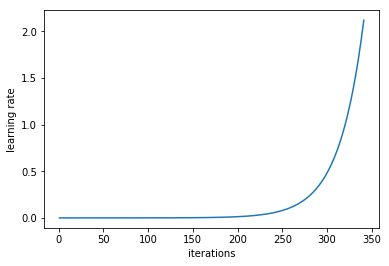

In [18]:
learn.sched.plot_lr()

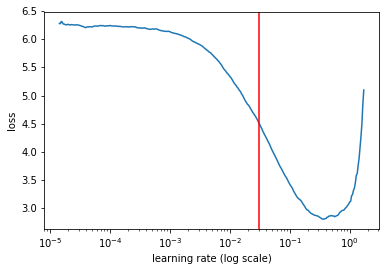

In [19]:
learn.sched.plot()
LEARN_RATE=3e-2
plt.axvline(x=LEARN_RATE, color="red");

In [20]:
learn.fit(LEARN_RATE, 1)
learn.precompute=False

epoch      trn_loss   val_loss   accuracy                   
    0      1.158867   0.735458   0.817513  


In [21]:
learn.precompute=False
learn.fit(LEARN_RATE, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                    
    0      0.904294   0.653421   0.837935  
    1      0.835906   0.620958   0.847084                    
    2      0.779384   0.599561   0.851005                    


[array([0.59956]), 0.8510047379242713]

In [22]:
learn.unfreeze()
lr=np.array([1e-4,1e-3,1e-2])

In [23]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.743965   0.52895    0.867342  
    1      0.620173   0.530651   0.864074                    
    2      0.299909   0.457266   0.879922                    
    3      0.478919   0.593324   0.854762                    
    4      0.232008   0.516221   0.878941                    
    5      0.122746   0.477014   0.888907                    
    6      0.099466   0.466518   0.889397                     


[array([0.46652]), 0.8893971573953983]

In [24]:
learn.save('224')

In [ ]:
learn.load('224')

In [ ]:
lr=np.array([1e-4,1e-3,1e-2])

In [25]:
learn.set_data(get_data(299, bs))

In [26]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.136568   0.448915   0.891521  
    1      0.112349   0.449451   0.894952                    
    2      0.101922   0.44519    0.896422                     
    3      0.102132   0.458792   0.891684                     
    4      0.092525   0.452525   0.895115                     
    5      0.082564   0.456052   0.895932                     
    6      0.070002   0.454491   0.895279                     


[array([0.45449]), 0.8952785492566574]

In [27]:
learn.save('299')

In [ ]:
learn.load('299')

In [28]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

accuracy_np(probs,y)

0.9026302891684366

## Save classes json file

In [ ]:
%mkdir /tmp/model

In [29]:
with open('/tmp/model/classes.json', 'w') as outfile:
    json.dump(json.dumps(all_lbls), outfile)

## Create tarball with model file

In [30]:
!cp data data/caltech_256/tmp/340/models/299.h5 /tmp/model/resnext50.h5
!tar czvf /tmp/model/model.tar.gz -C /tmp/model resnext50.h5 classes.json

caltech_256_resnext50_299.h5
classes.json


## Upload model to S3

In [ ]:
import boto3
region = boto3.session.Session().region_name
account_id = boto3.client('sts').get_caller_identity().get('Account')

bucket = 'sagemaker-{}-{}'.format(account_id, region)
print(f'Bucket is: {bucket}')

In [33]:
key='models/caltech256_fastai/model.tar.gz'   # prefix of the S3 bucket of the model file

In [34]:
boto3.client('s3').upload_file("/tmp/model/model.tar.gz", bucket, key)
print(f"Uploaded model artefacts to s3://{bucket}/{key}")

Uploaded model artefacts to s3://sagemaker-934676248949-eu-west-1/models/caltech256_fastai/model.tar.gz
